In [1]:
configs = {
    "Latte(S, latent)": "configs/training/kubric/movi_a/latent/small.yaml",
    "Latte(B, latent)": "configs/training/kubric/movi_a/latent/base.yaml",
    "Latte(L, latent)": "configs/training/kubric/movi_a/latent/large.yaml",
}

In [2]:
# "Best according to best-of-k"
ckpts = {
    "Latte(S, latent)": "/work/gabrijel/what-happnes-next-checkpoints/track-generator/kubric/latent/small/ckpt_epoch=380.pth",
    "Latte(B, latent)": "/work/gabrijel/what-happnes-next-checkpoints/track-generator/kubric/latent/base/ckpt_epoch=400.pth",
    "Latte(L, latent)": "/work/gabrijel/what-happnes-next-checkpoints/track-generator/kubric/latent/large/ckpt_epoch=310.pth",
}

In [3]:
import torch

model = "Latte(L, latent)"
device = torch.device("cuda:0")

In [4]:
from typing import Optional, Tuple
from omegaconf import DictConfig
from zipp import Path
from nn_latte import Latte
from nn_latte_vae import LatteVAE
from train_latent import sample_latte_latte_vae
from vae import decode_tracks_latte
from transformers import AutoModel, AutoImageProcessor
from omegaconf import OmegaConf
from core import get_model
from torchinfo import summary


@torch.inference_mode()
def sample_tracks(
    model: Latte,
    vae: LatteVAE,
    vae_scale: torch.Tensor,
    dino: AutoModel,
    dino_processor: AutoImageProcessor,
    reference_frames: torch.Tensor,
    device: torch.device,
    trajectory_stride: int,
    method: str,
    steps: int,
    atol: float,
    rtol: float,
    rng: Optional[torch.Generator] = None
):
    """
    Input:
      - reference_frames: [b, h, w, c]
    Output:
      - sampled tracks: [b, t, h, w, c]
    """
    if rng is None:
        rng = torch.Generator(device).manual_seed(42)

    tracktents = sample_latte_latte_vae(
        model,
        vae,
        vae_scale,
        dino,
        dino_processor,
        reference_frames,
        device,
        trajectory_stride=trajectory_stride,
        method=method,
        steps=steps,
        atol=atol,
        rtol=rtol,
        rng=rng
    )  # [b, t, c, h, w]
    tracks = decode_tracks_latte(
        vae,
        vae_scale,
        dino,
        dino_processor,
        tracktents,
        reference_frames.unsqueeze(1),
        device
    )  # [b, t, h, w, 2]
    return tracks


def load_denoiser(
    config: DictConfig,
    ckpt: Path,
    device: torch.device
) -> Latte:
    ckpt = torch.load(ckpt, map_location="cpu")
    model = get_model(config)
    model.load_state_dict({
        key.replace("module.", ""): value
        for (key, value) in ckpt["model_state_dict"].items()
    })
    model = model.to(device)
    model.eval()
    return model


def load_vae(
    config: DictConfig,
    device: torch.device
) -> Tuple[LatteVAE, torch.Tensor]:
    vae = LatteVAE(
        encoder_depth=12,
        decoder_depth=12,
        hidden_size=384,
        patch_size=2,
        num_heads=6,
        in_channels=2,
        latent_channels=8,
        input_size=32,
        num_frames=24,
        learn_sigma=False
    )
    ckpt = torch.load(
        config.model.vae.ckpt,
        map_location=device,
        weights_only=True
    )
    vae.load_state_dict(
        state_dict={
            k.replace("module.", ""): v
            for (k, v) in ckpt["model_state_dict"].items()
        }
    )
    vae_scale = 1.0 / torch.tensor(
        config.model.vae.scale,
        device=device
    )
    vae = vae.to(device)
    vae.eval()
    return vae, vae_scale

/users/gabrijel/miniconda3/envs/track-generator/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/athenahomes/gabrijel/miniconda3/envs/track-generator/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [5]:
# Load config
config = OmegaConf.load(configs[model])

In [6]:
# Load VAE
vae, vae_scale = load_vae(config, device)
summary(vae)

Layer (type:depth-idx)                             Param #
LatteVAE                                           205,824
├─TrackPosEncoder: 1-1                             --
│    └─LearnableFourierFeaturesEncoding: 2-1       128
│    │    └─Mlp: 3-1                               394,880
├─PatchEmbed: 1-2                                  --
│    └─Conv2d: 2-2                                 200,064
│    └─Identity: 2-3                               --
├─Linear: 1-3                                      147,840
├─Linear: 1-4                                      6,160
├─Linear: 1-5                                      3,456
├─ModuleList: 1-6                                  --
│    └─TransformerBlock: 2-4                       1,152
│    │    └─RMSNorm: 3-2                           384
│    │    └─SelfAttention: 3-3                     592,128
│    │    └─RMSNorm: 3-4                           384
│    │    └─CrossAttention: 3-5                    592,128
│    │    └─RMSNorm: 3-6           

In [7]:
# Load model
model = load_denoiser(config, ckpts[model], device)
summary(model)

/tmp/ipykernel_1826021/4206688671.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt, map_location="cpu")


Layer (type:depth-idx)                   Param #
Latte                                    --
├─PatchEmbed: 1-1                        --
│    └─Conv2d: 2-1                       6,912
│    └─Identity: 2-2                     --
├─TimestepEmbedder: 1-2                  --
│    └─Sequential: 2-3                   --
│    │    └─Linear: 3-1                  197,376
│    │    └─SiLU: 3-2                    --
│    │    └─Linear: 3-3                  590,592
├─Linear: 1-3                            295,680
├─ModuleList: 1-4                        --
│    └─TransformerBlock: 2-4             --
│    │    └─RMSNorm: 3-4                 --
│    │    └─SelfAttention: 3-5           2,363,904
│    │    └─CrossAttention: 3-6          2,363,904
│    │    └─RMSNorm: 3-7                 --
│    │    └─Mlp: 3-8                     4,722,432
│    │    └─Sequential: 3-9              4,134,144
│    └─TransformerBlock: 2-5             --
│    │    └─RMSNorm: 3-10                --
│    │    └─SelfAttention

In [8]:
from transformers import AutoImageProcessor, AutoModel

# Load DINO
processor = AutoImageProcessor.from_pretrained(
    "/scratch/shared/beegfs/gabrijel/hf/models--facebook--dinov2-small/snapshots/ed25f3a31f01632728cabb09d1542f84ab7b0056"  # noqa: E501
)
dino = AutoModel.from_pretrained(
    "/scratch/shared/beegfs/gabrijel/hf/models--facebook--dinov2-small/snapshots/ed25f3a31f01632728cabb09d1542f84ab7b0056"  # noqa: E501
)
dino = dino.to(device)
dino.eval()

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-11): 12 x Dinov2Layer(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2SdpaAttention(
          (attention): Dinov2SdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_pa

In [9]:
from pathlib import Path


scene_index = 43
rollout_index = 1

In [10]:
from sample_kubric_benchmark import get_sampling_seed
from seed import seed_everything


seed = get_sampling_seed(rollout_index)
seed_everything(seed)
rng = torch.Generator(device).manual_seed(seed)

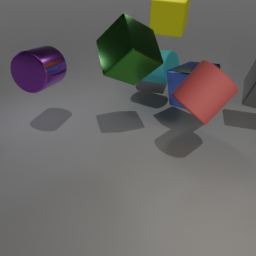

In [11]:
import numpy as np
from PIL import Image

reference_frame = Image.open("./demos/kubric/init_cond_0.png")
reference_frame.show()
reference_frame = torch.from_numpy(np.array(reference_frame))
h, w, c = reference_frame.shape

In [12]:
import time
import torch

num_times = 1
times = []
peak_memories = []

for _ in range(num_times):
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats(device)

    torch.cuda.synchronize()
    start = time.time()

    pred_tracks = sample_tracks(
        model,
        vae,
        vae_scale,
        dino,
        processor,
        reference_frame[None, ...],
        device,
        config.model.nn.trajectory_stride,
        "euler",
        10,
        1e-5,
        1e-5,
        torch.Generator(device).manual_seed(get_sampling_seed(rollout_index))
    )

    torch.cuda.synchronize()
    end = time.time()
    times.append(end - start)

    peak_mem = torch.cuda.max_memory_allocated(device) / 1024**3  # in GB
    peak_memories.append(peak_mem)

avg_time = sum(times) / len(times)
avg_peak_memory = sum(peak_memories) / len(peak_memories)

print(f"Average runtime over {num_times} runs: {avg_time:.4f} seconds")
print(f"Average peak GPU memory: {avg_peak_memory:.3f} GB")

sampling method=euler, steps=10, atol=1e-05, rtol=1e-05 ...
Average runtime over 1 runs: 4.5588 seconds
Average peak GPU memory: 1.949 GB


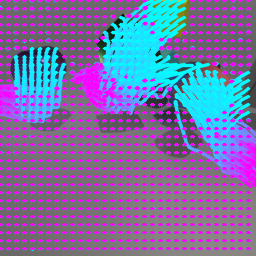

In [13]:
from einops import rearrange
from visualizations import plot_tracks_on_reference_frame


Image.fromarray(
    plot_tracks_on_reference_frame(
        tracks=rearrange(
            pred_tracks[0, ...],
            "t h w d -> () (h w) t d",
        ).detach().cpu().numpy(),
        reference_frames=reference_frame[None, ...].numpy()
    )[0, ...]
)